[Part 1](#Part-1)  
[Part 2](#Part-2)

# Part 1

In [1]:
import numpy as np
import jiwer
import spectral
import librosa
import IPython
import os, glob
import ast
import scipy.io.wavfile as wav
import sklearn
from sklearn.neural_network import MLPClassifier
import time
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from joblib import dump, load
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
%matplotlib inline
#random.seed(777)

Using TensorFlow backend.


In [2]:
def txt2list(filename):
    lines_list = []
    with open(filename, 'r') as txt:
        for line in txt:
            lines_list.append(line.rstrip('\n'))
    return lines_list

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav).flatten())
    return features

def pad(features, min_len=1):
    padded_features =[]
    for feat_file in features:
        min_len = max(min_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = min_len - feat_file.shape[0]
        left_pad = pad_size // 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

path_to_wav = './speech_commands/'
directories_speech_commands = os.listdir(path_to_wav)
directories_speech_commands = [x for x in directories_speech_commands if os.path.isdir(os.path.join(path_to_wav,x))]
directories_speech_commands = [x for x in directories_speech_commands if x != '_background_noise_']
directories_speech_commands
label_set = directories_speech_commands
nb_ex_per_class = 1000 # To have balance classes for the NN/Logistic Regression
# Valid set
valid_list = txt2list('./speech_commands/validation_list.txt')
# Test set
test_list = txt2list('./speech_commands/testing_list.txt')

In [3]:
len(label_set)

30

In [4]:
# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

start = time.time()

for root, dirs, files in os.walk("speech_commands"):
    if "_background_noise_" in root:
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.split("/")[-1]
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root, filename)
        partial_path = '/'.join([command, filename])
        if partial_path in valid_list: #and len(valid_labels) < 1000:
            fs, waveform = wav.read(full_name)
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif partial_path in test_list: #and len(test_labels) < 1000:
            fs, waveform = wav.read(full_name)
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            fs, waveform = wav.read(full_name)
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print("Train files:" + str(len(train_wavs)))
print("Valid files:" + str(len(valid_wavs)))
print("Test files:" + str(len(test_wavs)))

end = time.time()

print("Time to output features: " + str(end-start))

Train files:30000
Valid files:6798
Test files:6835
Time to output features: 164.30057907104492


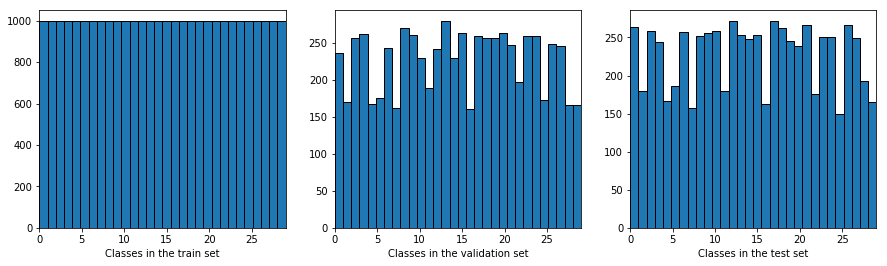

In [5]:
f, axs = plt.subplots(1, 3, figsize = (15,4))
axs[0].hist(train_labels, bins=30, color='C0', density=False, ec='black', )
axs[0].set_xlim(0,29)
axs[0].set_xlabel('Classes in the train set')
axs[1].hist(valid_labels, bins=30, color='C0', density=False, ec='black', )
axs[1].set_xlim(0,29)
axs[1].set_xlabel('Classes in the validation set')
axs[2].hist(test_labels, bins=30, color='C0', density=False, ec='black', )
axs[2].set_xlim(0,29)
axs[2].set_xlabel('Classes in the test set')
plt.savefig('plot.eps', bbox_inches='tight')
plt.show()

# I. Melfilter banks

## 1. Without deltas

In [44]:
framerate = 16000
melfbanks = spectral.Spectral(nfilt=26,
                    ncep=0,
                    do_dct=False,
                    lowerf=300, ####
                    upperf=8000, ####
                    alpha=0.97, #??
                    fs=framerate,
                    frate=100,  #??
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

# Choose the feature function
feature_function = melfbanks

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print("Time to output features: " + str(end-start))
print(train_feats.shape)

Time to output features: 346.20458817481995
(30000, 2626)


### a) Logistic regression with SGD

In [15]:
from sklearn.model_selection import GridSearchCV

logreg = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]
clf = GridSearchCV(estimator=logreg, param_grid=dict(alpha=alphas),
                   n_jobs=4, scoring='accuracy', cv=3)

start = time.time()
clf.fit(train_feats, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf.score(train_feats, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf.score(valid_feats, valid_labels)) + "%")
dump(clf, 'mel_nodelta_logreg_sgd.joblib') 

Training time: 327.3744127750397
Best alpha: 0.001
Accuracy on train set 30.73%
Accuracy on valid set 27.27272727272727%


['mel_nodelta_logreg_sgd.joblib']

### b) Logistic regression with SGD and scaled features

In [16]:
from sklearn import preprocessing

logreg_scaled = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]
clf_scaled = GridSearchCV(estimator=logreg_scaled, param_grid=dict(alpha=alphas),
                   n_jobs=4, scoring='accuracy', cv=3)

train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)

start = time.time()
clf_scaled.fit(train_feats_scaled, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf_scaled.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf_scaled.score(train_feats_scaled, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf_scaled.score(valid_feats_scaled, valid_labels)) + "%")
dump(clf_scaled, 'mel_nodelta_logreg_sgd_scaled.joblib') 

Training time: 373.6323437690735
Best alpha: 0.0001
Accuracy on train set 38.373333333333335%
Accuracy on valid set 32.671373933509855%


['mel_nodelta_logreg_sgd_scaled.joblib']

### c) MLP

In [38]:
train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mel_nodelta_keras.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats, train_labels2,  validation_data=(valid_feats, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 4s 127us/step - loss: 6.0453 - acc: 0.0493 - val_loss: 3.3003 - val_acc: 0.0858

Epoch 00001: val_acc improved from -inf to 0.08576, saving model to ./mel_nodelta_keras.hdf5
Epoch 2/100
30000/30000 [==============================] - 1s 49us/step - loss: 3.3075 - acc: 0.0806 - val_loss: 3.1487 - val_acc: 0.1322

Epoch 00002: val_acc improved from 0.08576 to 0.13224, saving model to ./mel_nodelta_keras.hdf5
Epoch 3/100
30000/30000 [==============================] - 1s 49us/step - loss: 3.1681 - acc: 0.1136 - val_loss: 2.9677 - val_acc: 0.1833

Epoch 00003: val_acc improved from 0.13224 to 0.18329, saving model to ./mel_nodelta_keras.hdf5
Epoch 4/100
30000/30000 [==============================] - 1s 49us/step - loss: 3.0308 - acc: 0.1465 - val_loss: 2.8406 - val_acc: 0.2195

Epoch 00004: val_acc improved from 0.18329 to 0.21948, saving model to ./mel_nodelta_keras.hdf5
Epoch 5/100
3

30000/30000 [==============================] - 1s 50us/step - loss: 0.9527 - acc: 0.7046 - val_loss: 1.0355 - val_acc: 0.6920

Epoch 00037: val_acc did not improve from 0.70756
Epoch 38/100
30000/30000 [==============================] - 1s 50us/step - loss: 0.9126 - acc: 0.7206 - val_loss: 1.0145 - val_acc: 0.7095

Epoch 00038: val_acc improved from 0.70756 to 0.70947, saving model to ./mel_nodelta_keras.hdf5
Epoch 39/100
30000/30000 [==============================] - 1s 50us/step - loss: 0.8943 - acc: 0.7248 - val_loss: 0.9905 - val_acc: 0.7127

Epoch 00039: val_acc improved from 0.70947 to 0.71271, saving model to ./mel_nodelta_keras.hdf5
Epoch 40/100
30000/30000 [==============================] - 1s 50us/step - loss: 0.8623 - acc: 0.7336 - val_loss: 0.9639 - val_acc: 0.7198

Epoch 00040: val_acc improved from 0.71271 to 0.71977, saving model to ./mel_nodelta_keras.hdf5
Epoch 41/100
30000/30000 [==============================] - 2s 50us/step - loss: 0.8294 - acc: 0.7414 - val_loss: 0

In [34]:
score, acc = model.evaluate(valid_feats, valid_labels2)
print('Validation accuracy:', acc)

6798/6798 [==============================] - 1s 101us/step
Validation accuracy: 0.6423948220240084


### d) MLP with scaled features

In [45]:
train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)

train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats_scaled.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mel_nodelta_keras_scaled.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats_scaled, train_labels2,  validation_data=(valid_feats_scaled, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 4s 148us/step - loss: 3.2671 - acc: 0.1127 - val_loss: 2.7804 - val_acc: 0.2510

Epoch 00001: val_acc improved from -inf to 0.25096, saving model to ./mel_nodelta_keras_scaled.hdf5
Epoch 2/100
30000/30000 [==============================] - 2s 55us/step - loss: 2.6558 - acc: 0.2539 - val_loss: 2.2225 - val_acc: 0.4185

Epoch 00002: val_acc improved from 0.25096 to 0.41851, saving model to ./mel_nodelta_keras_scaled.hdf5
Epoch 3/100
30000/30000 [==============================] - 2s 50us/step - loss: 2.1916 - acc: 0.3756 - val_loss: 1.8260 - val_acc: 0.5154

Epoch 00003: val_acc improved from 0.41851 to 0.51545, saving model to ./mel_nodelta_keras_scaled.hdf5
Epoch 4/100
30000/30000 [==============================] - 1s 50us/step - loss: 1.8511 - acc: 0.4710 - val_loss: 1.5838 - val_acc: 0.5750

Epoch 00004: val_acc improved from 0.51545 to 0.57502, saving model to ./mel_nodelta_ker

In [46]:
score, acc = model.evaluate(valid_feats_scaled, valid_labels2)
print('Validation accuracy:', acc)

6798/6798 [==============================] - 1s 91us/step
Validation accuracy: 0.7563989408824963


## 2. With deltas

In [39]:
framerate = 16000
melfbanks = spectral.Spectral(nfilt=26,
                    ncep=0,
                    do_dct=False,
                    lowerf=300, ####
                    upperf=8000, ####
                    alpha=0.97, #??
                    fs=framerate,
                    frate=100,  #??
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=True)

# Choose the feature function
feature_function = melfbanks

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print("Time to output features: " + str(end-start))
print(train_feats.shape)

Time to output features: 381.68870282173157
(30000, 7878)


### a) Logistic regression with SGD

In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_score

logreg = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

clf = GridSearchCV(estimator=logreg, param_grid=dict(alpha=alphas),
                   n_jobs=2, scoring='accuracy', cv=3)

start = time.time()
clf.fit(train_feats, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf.score(train_feats, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf.score(valid_feats, valid_labels)) + "%")
dump(clf, 'mel_delta_logreg_sgd.joblib') 

Training time: 937.4954125881195
Best alpha: 0.0001
Accuracy on train set 30.583333333333336%
Accuracy on valid set 25.59576345984113%


['mel_delta_logreg_sgd.joblib']

### b) Logistic regression with SGD and scaled features

In [10]:
from sklearn import preprocessing

logreg_scaled = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

clf_scaled = GridSearchCV(estimator=logreg_scaled, param_grid=dict(alpha=alphas),
                   n_jobs=2, scoring='accuracy', cv=3)

train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)

start = time.time()
clf_scaled.fit(train_feats_scaled, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf_scaled.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf_scaled.score(train_feats_scaled, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf_scaled.score(valid_feats_scaled, valid_labels)) + "%")
dump(clf_scaled, 'mel_delta_logreg_sgd_scaled.joblib') 

Training time: 1072.4696192741394
Best alpha: 0.0001
Accuracy on train set 38.36666666666667%
Accuracy on valid set 27.993527508090615%


['mel_delta_logreg_sgd_scaled.joblib']

### c) MLP

In [40]:
train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mel_delta_keras.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats, train_labels2,  validation_data=(valid_feats, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 6s 208us/step - loss: 4.8442 - acc: 0.0565 - val_loss: 3.2002 - val_acc: 0.1169

Epoch 00001: val_acc improved from -inf to 0.11695, saving model to ./mel_delta_keras.hdf5
Epoch 2/100
30000/30000 [==============================] - 4s 129us/step - loss: 3.1713 - acc: 0.1106 - val_loss: 2.9214 - val_acc: 0.2224

Epoch 00002: val_acc improved from 0.11695 to 0.22242, saving model to ./mel_delta_keras.hdf5
Epoch 3/100
30000/30000 [==============================] - 4s 122us/step - loss: 2.9368 - acc: 0.1673 - val_loss: 2.6619 - val_acc: 0.2774

Epoch 00003: val_acc improved from 0.22242 to 0.27743, saving model to ./mel_delta_keras.hdf5
Epoch 4/100
30000/30000 [==============================] - 4s 119us/step - loss: 2.7103 - acc: 0.2238 - val_loss: 2.4134 - val_acc: 0.3267

Epoch 00004: val_acc improved from 0.27743 to 0.32671, saving model to ./mel_delta_keras.hdf5
Epoch 5/100
30000/

In [41]:
score, acc = model.evaluate(valid_feats, valid_labels2)
print('Validation accuracy:', acc)

6798/6798 [==============================] - 1s 139us/step
Validation accuracy: 0.7328626066139425


### d) MLP with scaled features

In [42]:
train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)


train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats_scaled.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mel_delta_keras_scaled.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats_scaled, train_labels2,  validation_data=(valid_feats_scaled, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 6s 205us/step - loss: 2.9313 - acc: 0.2117 - val_loss: 2.1277 - val_acc: 0.4216

Epoch 00001: val_acc improved from -inf to 0.42159, saving model to ./mel_delta_keras_scaled.hdf5
Epoch 2/100
30000/30000 [==============================] - 4s 122us/step - loss: 2.0353 - acc: 0.4181 - val_loss: 1.6228 - val_acc: 0.5455

Epoch 00002: val_acc improved from 0.42159 to 0.54545, saving model to ./mel_delta_keras_scaled.hdf5
Epoch 3/100
30000/30000 [==============================] - 4s 117us/step - loss: 1.5965 - acc: 0.5325 - val_loss: 1.3577 - val_acc: 0.6247

Epoch 00003: val_acc improved from 0.54545 to 0.62474, saving model to ./mel_delta_keras_scaled.hdf5
Epoch 4/100
30000/30000 [==============================] - 4s 117us/step - loss: 1.3264 - acc: 0.6125 - val_loss: 1.2014 - val_acc: 0.6603

Epoch 00004: val_acc improved from 0.62474 to 0.66034, saving model to ./mel_delta_keras_sc

In [43]:
score, acc = model.evaluate(valid_feats_scaled, valid_labels2)
print('Validation accuracy:', acc)

6798/6798 [==============================] - 1s 141us/step
Validation accuracy: 0.7590467784291823


***

# II. MFCC

## 1. Without deltas

In [47]:
framerate = 16000
mfcc = spectral.Spectral(nfilt=26,
                    ncep=13,
                    do_dct=True,
                    lowerf=300,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print("Time to output features: " + str(end-start))
print(train_feats.shape)

Time to output features: 385.4943368434906
(30000, 1313)


### a) Logistic regression with SGD

In [12]:
from sklearn.model_selection import GridSearchCV

logreg = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]
clf = GridSearchCV(estimator=logreg, param_grid=dict(alpha=alphas),
                   n_jobs=4, scoring='accuracy', cv=3)

start = time.time()
clf.fit(train_feats, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf.score(train_feats, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf.score(valid_feats, valid_labels)) + "%")
dump(clf, 'mfcc_nodelta_logreg_sgd.joblib') 

Training time: 214.03309178352356
Best alpha: 0.0005
Accuracy on train set 26.3%
Accuracy on valid set 24.845542806707854%


['mfcc_nodelta_logreg_sgd.joblib']

### b) Logistic regression with SGD and scaled features

In [13]:
from sklearn import preprocessing

logreg_scaled = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]
clf_scaled = GridSearchCV(estimator=logreg_scaled, param_grid=dict(alpha=alphas),
                   n_jobs=4, scoring='accuracy', cv=3)

train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)

start = time.time()
clf_scaled.fit(train_feats_scaled, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf_scaled.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf_scaled.score(train_feats_scaled, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf_scaled.score(valid_feats_scaled, valid_labels)) + "%")
dump(clf_scaled, 'mfcc_nodelta_logreg_sgd_scaled.joblib') 

Training time: 217.58822870254517
Best alpha: 0.0001
Accuracy on train set 37.5%
Accuracy on valid set 28.390703147984702%


['mfcc_nodelta_logreg_sgd_scaled.joblib']

### c) MLP

In [48]:
train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mfcc_nodelta_keras.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats, train_labels2,  validation_data=(valid_feats, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])


score, acc = model.evaluate(valid_feats, valid_labels2)
print('Validation accuracy:', acc)

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 4s 121us/step - loss: 3.9268 - acc: 0.0511 - val_loss: 3.2512 - val_acc: 0.1161

Epoch 00001: val_acc improved from -inf to 0.11606, saving model to ./mfcc_nodelta_keras.hdf5
Epoch 2/100
30000/30000 [==============================] - 1s 32us/step - loss: 3.1923 - acc: 0.1096 - val_loss: 2.9918 - val_acc: 0.1940

Epoch 00002: val_acc improved from 0.11606 to 0.19403, saving model to ./mfcc_nodelta_keras.hdf5
Epoch 3/100
30000/30000 [==============================] - 1s 31us/step - loss: 2.9450 - acc: 0.1726 - val_loss: 2.6939 - val_acc: 0.2757

Epoch 00003: val_acc improved from 0.19403 to 0.27567, saving model to ./mfcc_nodelta_keras.hdf5
Epoch 4/100
30000/30000 [==============================] - 1s 32us/step - loss: 2.6745 - acc: 0.2407 - val_loss: 2.4073 - val_acc: 0.3651

Epoch 00004: val_acc improved from 0.27567 to 0.36511, saving model to ./mfcc_nodelta_keras.hdf5
Epoch 5/1

### d) MLP with scaled features

In [49]:
train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)

train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats_scaled.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mfcc_nodelta_keras_scaled.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats_scaled, train_labels2,  validation_data=(valid_feats_scaled, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])


score, acc = model.evaluate(valid_feats_scaled, valid_labels2)
print('Validation accuracy:', acc)

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 3s 117us/step - loss: 3.2009 - acc: 0.1207 - val_loss: 2.6769 - val_acc: 0.2749

Epoch 00001: val_acc improved from -inf to 0.27493, saving model to ./mfcc_nodelta_keras_scaled.hdf5
Epoch 2/100
30000/30000 [==============================] - 1s 32us/step - loss: 2.5157 - acc: 0.2847 - val_loss: 2.1722 - val_acc: 0.4011

Epoch 00002: val_acc improved from 0.27493 to 0.40115, saving model to ./mfcc_nodelta_keras_scaled.hdf5
Epoch 3/100
30000/30000 [==============================] - 1s 32us/step - loss: 2.0903 - acc: 0.3971 - val_loss: 1.8703 - val_acc: 0.4754

Epoch 00003: val_acc improved from 0.40115 to 0.47543, saving model to ./mfcc_nodelta_keras_scaled.hdf5
Epoch 4/100
30000/30000 [==============================] - 1s 32us/step - loss: 1.7640 - acc: 0.4902 - val_loss: 1.6403 - val_acc: 0.5397

Epoch 00004: val_acc improved from 0.47543 to 0.53972, saving model to ./mfcc_nodelta

## 2. With deltas

In [50]:
framerate = 16000
mfcc = spectral.Spectral(nfilt=26,
                    ncep=13,
                    do_dct=True,
                    lowerf=300,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=True)
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print("Time to output features: " + str(end-start))
print(train_feats.shape)

Time to output features: 423.2389249801636
(30000, 3939)


### a) Logistic regression with SGD

In [15]:
from sklearn.model_selection import GridSearchCV, cross_val_score

logreg = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

clf = GridSearchCV(estimator=logreg, param_grid=dict(alpha=alphas),
                   n_jobs=2, scoring='accuracy', cv=3)

start = time.time()
clf.fit(train_feats, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf.score(train_feats, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf.score(valid_feats, valid_labels)) + "%")
dump(clf, 'mfcc_delta_logreg_sgd.joblib') 

Training time: 554.0569298267365
Best alpha: 0.0001
Accuracy on train set 28.12%
Accuracy on valid set 25.757575757575758%


['mfcc_delta_logreg_sgd.joblib']

### b) Logistic regression with SGD and scaled features

In [16]:
from sklearn import preprocessing

logreg_scaled = sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', n_jobs=4,
                                            learning_rate='optimal', early_stopping=True, tol=1,
                                            validation_fraction=0.3, n_iter_no_change=5)

alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

clf_scaled = GridSearchCV(estimator=logreg_scaled, param_grid=dict(alpha=alphas),
                   n_jobs=2, scoring='accuracy', cv=3)

train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)

start = time.time()
clf_scaled.fit(train_feats_scaled, train_labels)
end = time.time()
print("Training time: " + str(end-start))
print("Best alpha:", clf_scaled.best_estimator_.alpha)
print("Accuracy on train set " + str(100*clf_scaled.score(train_feats_scaled, train_labels)) + "%")
print("Accuracy on valid set " + str(100*clf_scaled.score(valid_feats_scaled, valid_labels)) + "%")
dump(clf_scaled, 'mfcc_delta_logreg_sgd_scaled.joblib') 

Training time: 590.7417721748352
Best alpha: 0.0001
Accuracy on train set 39.73%
Accuracy on valid set 28.89085025007355%


['mfcc_delta_logreg_sgd_scaled.joblib']

### c) MLP

In [51]:
train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mfcc_delta_keras.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats, train_labels2,  validation_data=(valid_feats, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])

score, acc = model.evaluate(valid_feats, valid_labels2)
print('Validation accuracy:', acc)

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 5s 168us/step - loss: 3.4848 - acc: 0.0655 - val_loss: 3.1675 - val_acc: 0.1417

Epoch 00001: val_acc improved from -inf to 0.14166, saving model to ./mfcc_delta_keras.hdf5
Epoch 2/100
30000/30000 [==============================] - 2s 68us/step - loss: 3.0477 - acc: 0.1518 - val_loss: 2.7443 - val_acc: 0.2570

Epoch 00002: val_acc improved from 0.14166 to 0.25699, saving model to ./mfcc_delta_keras.hdf5
Epoch 3/100
30000/30000 [==============================] - 2s 65us/step - loss: 2.7138 - acc: 0.2271 - val_loss: 2.4175 - val_acc: 0.3391

Epoch 00003: val_acc improved from 0.25699 to 0.33907, saving model to ./mfcc_delta_keras.hdf5
Epoch 4/100
30000/30000 [==============================] - 2s 63us/step - loss: 2.3952 - acc: 0.3105 - val_loss: 2.1033 - val_acc: 0.4232

Epoch 00004: val_acc improved from 0.33907 to 0.42321, saving model to ./mfcc_delta_keras.hdf5
Epoch 5/100
30000

### d) MLP with scaled features

In [52]:
#MLP with scaled features
train_feats_scaled = preprocessing.scale(train_feats)
valid_feats_scaled = preprocessing.scale(valid_feats)


train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)

model = Sequential()
model.add(Dense(2048, activation='relu', input_dim=train_feats_scaled.shape[1]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(30, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto', verbose=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, mode='auto')
checkpointer = ModelCheckpoint(filepath='./mfcc_delta_keras_scaled.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True)

model.fit(train_feats_scaled, train_labels2,  validation_data=(valid_feats_scaled, valid_labels2), 
          epochs=100, batch_size=1024, callbacks=[checkpointer, early])


score, acc = model.evaluate(valid_feats_scaled, valid_labels2)
print('Validation accuracy:', acc)

Train on 30000 samples, validate on 6798 samples
Epoch 1/100
30000/30000 [==============================] - 5s 172us/step - loss: 3.1535 - acc: 0.1416 - val_loss: 2.5067 - val_acc: 0.3217

Epoch 00001: val_acc improved from -inf to 0.32171, saving model to ./mfcc_delta_keras_scaled.hdf5
Epoch 2/100
30000/30000 [==============================] - 2s 62us/step - loss: 2.3235 - acc: 0.3418 - val_loss: 1.9143 - val_acc: 0.4741

Epoch 00002: val_acc improved from 0.32171 to 0.47411, saving model to ./mfcc_delta_keras_scaled.hdf5
Epoch 3/100
30000/30000 [==============================] - 2s 63us/step - loss: 1.8436 - acc: 0.4690 - val_loss: 1.5676 - val_acc: 0.5652

Epoch 00003: val_acc improved from 0.47411 to 0.56517, saving model to ./mfcc_delta_keras_scaled.hdf5
Epoch 4/100
30000/30000 [==============================] - 2s 62us/step - loss: 1.5077 - acc: 0.5611 - val_loss: 1.3672 - val_acc: 0.6147

Epoch 00004: val_acc improved from 0.56517 to 0.61474, saving model to ./mfcc_delta_keras_s

## Performance of the best model on the test set

In [7]:
framerate = 16000
mfcc = spectral.Spectral(nfilt=26,
                    ncep=13,
                    do_dct=True,
                    lowerf=300,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=True)
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print("Time to output features: " + str(end-start))
print(train_feats.shape)

model = load_model('./mfcc_delta_keras.hdf5')

train_labels2 = keras.utils.to_categorical(train_labels, num_classes=30)
valid_labels2 = keras.utils.to_categorical(valid_labels, num_classes=30)
test_labels2 = keras.utils.to_categorical(test_labels, num_classes=30)

score1, acc1 = model.evaluate(valid_feats, valid_labels2)
score2, acc2 = model.evaluate(test_feats, test_labels2)
print('Validation accuracy:', acc1)
print('Test accuracy:', acc2)

Time to output features: 364.38109064102173
(30000, 3939)
6835/6835 [==============================] - 1s 106us/step
Validation accuracy: 0.7702265371817566
Test accuracy: 0.7599122165063915


***

# Part 2

In [8]:
#!wget https://raw.githubusercontent.com/Rachine/Rachine.github.io/master/data/train_sequence_list.txt 
#!wget https://raw.githubusercontent.com/Rachine/Rachine.github.io/master/data/test_sequence_list.txt 


path_to_wavs = './speech_commands/'
train_sequence_list = [ast.literal_eval(ex) for ex in txt2list('./train_sequence_list.txt') ]
test_sequence_list = [ast.literal_eval(ex) for ex in txt2list('./test_sequence_list.txt') ]

def generate_wav_from_list_sequence(generated_list_sequence): 
    wavs = np.array([])
    for command in generated_list_sequence[1:]:
        wav_name = os.path.join((path_to_wavs),command[1])
        sample_rate, signal = wav.read(wav_name)
        wavs = np.append(wavs,signal)
    return wavs


# Again warning do not forget to change your pad function according to your choice of input features
  
def generate_posteriors_from_list_sequence(generated_list_sequence, model_predict_proba_function, feature_func): 
    posteriors = []
    for command in generated_list_sequence[1:]:
        wav_name = os.path.join((path_to_wavs),command[1])
        sample_rate, signal = wav.read(wav_name)
        features_input = np.asarray(pad(transform_wavs([signal], feature_function)))
        posterior = model_predict_proba_function(features_input)
        posteriors.append(posterior)
    
    posteriors = np.array(posteriors).reshape(-1,len(label_set))
    return posteriors

example_sequence = train_sequence_list[20]
sequence_wav  = generate_wav_from_list_sequence(example_sequence)

IPython.display.Audio(sequence_wav, rate=16000)


In [9]:
framerate = 16000
mfcc = spectral.Spectral(nfilt=26,
                    ncep=13,
                    do_dct=True,
                    lowerf=300,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=100,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=True)
# Choose the feature function
feature_function = mfcc
model = load_model('./mfcc_delta_keras.hdf5')

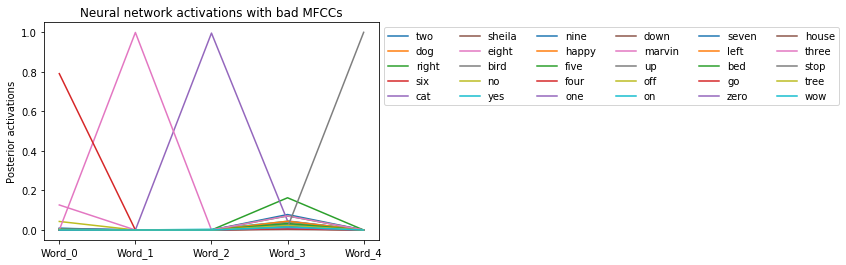

True sentence:  go marvin one right stop
Predicted sentence with greedy search:  go marvin one right stop
WER:  0.0


In [13]:
example_sequence = train_sequence_list[10]

posteriors_neural_mfcc = np.array(
    generate_posteriors_from_list_sequence(example_sequence, model.predict_proba, mfcc))


list_plots = plt.plot(['Word_'+str(el) for el in range(posteriors_neural_mfcc.shape[0])],posteriors_neural_mfcc)
plt.legend(list_plots, label_set, loc="upper left", bbox_to_anchor=(1,1), ncol=6)
plt.ylabel('Posterior activations')
plt.title('Neural network activations with bad MFCCs')
plt.show()


def greedy_decoder(data):
    predicted_sequence = [np.argmax(s) for s in data]
    predicted_sequence = [label_set[el] for el in predicted_sequence]
    return predicted_sequence

def sequence_format_to_text(sentence):
    return [el[0] for el in sentence[1:]]

predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
print('True sentence: ', ' '.join(sequence_format_to_text(example_sequence)))
print('Predicted sentence with greedy search: ', ' '.join(predicted_sequence))
print('WER: ',jiwer.wer(' '.join(sequence_format_to_text(example_sequence)),' '.join(predicted_sequence)))

In [11]:
# Evaluation of WER for the Greedy Search decoding

train_hypothesis = []
train_reference = []

# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
    posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, model.predict_proba, mfcc))
    predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
    train_hypothesis.append(' '.join(predicted_sequence))
    train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
    posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, model.predict_proba, mfcc))
    predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
    test_hypothesis.append(' '.join(predicted_sequence))
    test_reference.append(' '.join(sequence_format_to_text(sentence)))

start = time.time()
print('Subset Train WER: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


Subset Train WER:  0.2642543859649123
Test WER:  0.2657952069716776
Evaluation time: 56.27034640312195


In [69]:
#Build HERE the transition matrix with Uni-Gram and Bi-gram modelling. 
#You can also do an implementation with bigger N.

size = len(label_set)
transmat = np.ones((size,size))  #Initialize with a matrix of ones: Laplace smoothing
dic = {word:i for (i,word) in enumerate(label_set)}
sequences = [[l[0] for l in seq[1:]] for seq in train_sequence_list]
bigrams = [(seq[i], seq[i+1]) for seq in sequences for i in range(len(seq)-1)]
for (w1,w2) in bigrams:
    transmat[dic[w1], dic[w2]] += 1 #Increment count
for i in range(size):
    if np.sum(transmat[i,:]) > 0:
        transmat[i,:] /= np.sum(transmat[i,:])  #Normalize to get probability

In [116]:
# Beam Search decoder
def beam_search_decoder(data, transition_matrix, beam_size=5):
    #Initialize beam_size single words using the highest probabilities given by the discriminator
    #To avoid underflows we work in log space 
    sequences = [([i], np.log(transition_matrix[0,i])) 
                 for i in np.argpartition(transition_matrix[0,:], -beam_size)[-beam_size:]]
    #Loop over spoken words
    for i in range(1,len(data)):
        candidates = []  #List of candidate sequences
        for (seq, score) in sequences:
            #Compute scores that take into account the bigram language model
            scores = score + np.log(data[i]) + np.log(transition_matrix[seq[-1]])  
            #Update list of candidates
            candidates = candidates + [(seq+[j], scores[j]) for j in range(data.shape[1])]
        #Keep beam_size candidates with the highest scores
        ordered = sorted(candidates, key=lambda tup:tup[1], reverse=True)
        #Complexity could be reduced to linear by using argpartition instead of sorting the whole list
        sequences = ordered[:beam_size]      
            
    index = np.argmax([score for (seq, score) in sequences])
    seq = sequences[index][0]
    predicted_sequence = [label_set[el] for el in seq]
    return predicted_sequence

In [118]:
example_sequence = train_sequence_list[10]

size = 5
posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(example_sequence, model.predict_proba, mfcc))
predicted_sequence = beam_search_decoder(posteriors_neural_mfcc, transmat, size)
predicted_sequence_greedy = greedy_decoder(posteriors_neural_mfcc)
print('True sentence: ', ' '.join(sequence_format_to_text(example_sequence)))
print('Predicted sentence with beam search size '+str(size)+': ', ' '.join(predicted_sequence))
print('Predicted sentence with greedy search: ', ' '.join(predicted_sequence_greedy))
print('WER: ',jiwer.wer(' '.join(sequence_format_to_text(example_sequence)),' '.join(predicted_sequence)))

True sentence:  go marvin one right stop
Predicted sentence with beam search size 5:  up marvin one right stop
Predicted sentence with greedy search:  go marvin one right stop
WER:  0.2


In [119]:
# Viterbi decoder
def viterbi_decoder(data,transition_matrix):
    seq_len, vocab_len = data.shape 
    states = np.zeros((vocab_len, seq_len), dtype=int)
    probas = np.zeros((vocab_len, seq_len))
    sequence = np.zeros(seq_len, dtype=int) 
    
    init = np.full(vocab_len, 1/vocab_len)
    
    probas[:,0] = np.multiply(init, data[0, :])
    
    for i in range(1, seq_len):
        for j in range(vocab_len):
            update = np.multiply(probas[:,i-1], transition_matrix[:,j])
            states[j,i] = np.argmax(update)
            probas[j,i] = update[states[j,i]]*data[i, j]

    sequence[-1] = np.argmax(probas[:,-1])
    for i in reversed(range(seq_len-1)):
        sequence[i] = states[(sequence[i+1]), i+1]

    predicted_sequence = [label_set[el] for el in sequence]
    return predicted_sequence

In [121]:
example_sequence = train_sequence_list[10]

size = 5
posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(example_sequence, model.predict_proba, mfcc))
predicted_sequence = viterbi_decoder(posteriors_neural_mfcc, transmat)
predicted_sequence_beam = beam_search_decoder(posteriors_neural_mfcc, transmat, size)
predicted_sequence_greedy = greedy_decoder(posteriors_neural_mfcc)
print('True sentence: ', ' '.join(sequence_format_to_text(example_sequence)))
print('Predicted sentence with viterbi search: ', ' '.join(predicted_sequence))
print('Predicted sentence with beam search size '+str(size)+': ', ' '.join(predicted_sequence_beam))
print('Predicted sentence with greedy search: ', ' '.join(predicted_sequence_greedy))
print('WER: ',jiwer.wer(' '.join(sequence_format_to_text(example_sequence)),' '.join(predicted_sequence)))

True sentence:  go marvin one right stop
Predicted sentence with viterbi search:  go marvin one right stop
Predicted sentence with beam search size 5:  up marvin one right stop
Predicted sentence with greedy search:  go marvin one right stop
WER:  0.0


In [124]:
# Evaluation of WER for beam-search decoding
gen_post = generate_posteriors_from_list_sequence
data = model.predict_proba
subset_train = np.random.choice(train_sequence_list, 300, 
                                 replace=False)
beam_sizes = range(1, 6)
post_neural_trains = []
post_neural_tests = []

for sentence in subset_train:
    post_neural_trains.append(
        np.array(gen_post(sentence, data, mfcc)))
        
for sentence in test_sequence_list:
    post_neural_tests.append(
        np.array(gen_post(sentence, data, mfcc)))
    
for beam_size in beam_sizes:
    train_hypothesis = []
    train_reference = []

    for sentence, post_neural_train in zip(subset_train, post_neural_trains):
        predicted_sequence = beam_search_decoder(post_neural_train, transmat, beam_size)
        train_hypothesis.append(' '.join(predicted_sequence))
        train_reference.append(' '.join(sequence_format_to_text(sentence)))


    test_hypothesis = []
    test_reference = []
    for sentence, post_neural_test in zip(test_sequence_list, post_neural_tests):
        predicted_sequence = beam_search_decoder(post_neural_test, transmat, beam_size)
        test_hypothesis.append(' '.join(predicted_sequence))
        test_reference.append(' '.join(sequence_format_to_text(sentence)))

    print("Beam size", beam_size)
    start = time.time()
    print('\tSubset Train WER: ',jiwer.wer(train_reference, train_hypothesis))
    print('\tTest WER: ',jiwer.wer(test_reference, test_hypothesis))
    end = time.time()
    print("\tEvaluation time: " + str(end-start))

Beam size 1
	Subset Train WER:  0.41620727673649394
	Test WER:  0.4068627450980392
	Evaluation time: 56.11889290809631
Beam size 2
	Subset Train WER:  0.4145534729878721
	Test WER:  0.4025054466230937
	Evaluation time: 56.993513345718384
Beam size 3
	Subset Train WER:  0.402425578831312
	Test WER:  0.3899782135076253
	Evaluation time: 56.08376097679138
Beam size 4
	Subset Train WER:  0.3814773980154355
	Test WER:  0.36764705882352944
	Evaluation time: 56.23930764198303
Beam size 5
	Subset Train WER:  0.33517089305402425
	Test WER:  0.340958605664488
	Evaluation time: 56.85366106033325


In [127]:
# Evaluation of WER for Viterbi decoding

train_hypothesis = []
train_reference = []

# EVALUATION on the full train set takes too much time, so you should evaluate on a subset

for sentence in  np.random.choice(train_sequence_list, 300, replace=False):
    posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, model.predict_proba, mfcc))
    predicted_sequence = greedy_decoder(posteriors_neural_mfcc)
    train_hypothesis.append(' '.join(predicted_sequence))
    train_reference.append(' '.join(sequence_format_to_text(sentence)))
  
  
test_hypothesis = []
test_reference = []
for idx, sentence in enumerate(test_sequence_list):
    posteriors_neural_mfcc = np.array(generate_posteriors_from_list_sequence(sentence, model.predict_proba, mfcc))
    predicted_sequence = viterbi_decoder(posteriors_neural_mfcc, transmat)
    test_hypothesis.append(' '.join(predicted_sequence))
    test_reference.append(' '.join(sequence_format_to_text(sentence)))

start = time.time()
print('Subset Train WER: ',jiwer.wer(train_reference, train_hypothesis))
print('Test WER: ',jiwer.wer(test_reference, test_hypothesis))

end = time.time()

print("Evaluation time: " + str(end-start))


Subset Train WER:  0.2779623477297896
Test WER:  0.09041394335511982
Evaluation time: 56.52092146873474
